In [1]:
from itertools import chain
from itertools import compress
from pathlib import Path
from typing import Optional

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Batch
from torch_geometric.data import HeteroData

from losses import MixtureNLLLoss
from losses import NLLLoss
from metrics import Brier
from metrics import MR
from metrics import minADE
from metrics import minAHE
from metrics import minFDE
from metrics import minFHE

from modules.encoder import QCNetEncoder

try:
    from av2.datasets.motion_forecasting.eval.submission import ChallengeSubmission
except ImportError:
    ChallengeSubmission = object

class MikuMikuNet(pl.LightningModule):
    def __init__(self,
                 dataset: str,pl2pl_radius: float, pl2a_radius: float,a2a_radius: float,pl2m_radius: float,a2m_radius: float,
                 input_dim=2,
                 hidden_dim=128,
                 output_dim=2,
                 output_head=2,
                 num_historical_steps=50,
                 num_future_steps=60,
                 num_modes=6,
                 num_recurrent_steps=2,
                 num_freq_bands=64,
                 num_map_layers=1,
                 num_agent_layers=2,
                 num_dec_layers=2,
                 num_heads=8,
                 head_dim=16,
                 dropout=0.1,
                 time_span=None,  
                 num_t2m_steps=None,
                 lr=5e-4,
                 weight_decay=1e-4,
                 T_max=64,
                 submission_dir='./',
                 submission_file_name='submission',
                 **kwargs) -> None:
        super(MikuMikuNet, self).__init__()
        self.save_hyperparameters()
        self.dataset = dataset
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.output_head = output_head
        self.num_historical_steps = num_historical_steps
        self.num_future_steps = num_future_steps
        self.num_modes = num_modes
        self.num_recurrent_steps = num_recurrent_steps
        self.num_freq_bands = num_freq_bands
        self.num_map_layers = num_map_layers
        self.num_agent_layers = num_agent_layers
        self.num_dec_layers = num_dec_layers
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        self.pl2pl_radius = pl2pl_radius
        self.time_span = time_span
        self.pl2a_radius = pl2a_radius
        self.a2a_radius = a2a_radius
        self.num_t2m_steps = num_t2m_steps
        self.pl2m_radius = pl2m_radius
        self.a2m_radius = a2m_radius
        self.lr = lr
        self.weight_decay = weight_decay
        self.T_max = T_max
        self.submission_dir = submission_dir
        self.submission_file_name = submission_file_name


        self.anchors = Pts_anchor()
        self.encoder = QCNetEncoder(
            dataset=dataset,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_historical_steps=num_historical_steps,
            pl2pl_radius=pl2pl_radius,
            time_span=time_span,
            pl2a_radius=pl2a_radius,
            a2a_radius=a2a_radius,
            num_freq_bands=num_freq_bands,
            num_map_layers=num_map_layers,
            num_agent_layers=num_agent_layers,
            num_heads=num_heads,
            head_dim=head_dim,
            dropout=dropout,
        )



        self.reg_loss = NLLLoss(component_distribution=['laplace'] * output_dim + ['von_mises'] * output_head,
                                reduction='none')
        self.cls_loss = MixtureNLLLoss(component_distribution=['laplace'] * output_dim + ['von_mises'] * output_head,
                                       reduction='none')

        self.Brier = Brier(max_guesses=6)
        self.minADE = minADE(max_guesses=6)
        self.minAHE = minAHE(max_guesses=6)
        self.minFDE = minFDE(max_guesses=6)
        self.minFHE = minFHE(max_guesses=6)
        self.MR = MR(max_guesses=6)

        self.test_predictions = dict()

        self.anchor = Pts_anchor()



    def forward(self, data: HeteroData):
        scene_enc = self.encoder(data)
        anchor_output = self.anchor(data)
        return scene_enc, data, anchor_output
    
    def training_step(self, data,batch_index):
        pred, data, anchor_output=self(data)
        #print(data)
        #print('*'*100)
        #print(pred.keys())
        #print(pred['x_pt'].shape)
        #print(pred['x_pl'].shape)
        #print(pred['x_a'].shape)

        #print(anchor_output)
        #print('*'*100)
        return None
    def validation_step(self,data,batch_index ):
        pass
    def test_step(self,data,batch_index):
        pass
    def configure_optimizers(self):
        return None

In [2]:
import torch
import torch.nn as nn
from torch_cluster import radius_graph
from torch_cluster import radius
from torch_geometric.data import Batch

import matplotlib.pyplot as plt
from layers import FourierEmbedding

from utils.circle import minimum_enclosing_circle
from modules.encoder import QCNetEncoder

from torch_geometric.utils import dense_to_sparse

from layers.attention_layer import AttentionLayer


#class Adj_attn()

class Pts_anchor(nn.Module):
    def __init__(self) -> None:
        super(Pts_anchor,self).__init__()
        #self.adj_attn = Adj_atten
        #self.map_attn = Map_attn

    def forward(self, data, history_step=50, dim = 2):
        agent_pts_t0=data['agent']['position'][:,history_step,:dim]
        agent_vel_t0=data['agent']['velocity'][:,history_step,:dim]
        anchor_t1 = self.generate_trajectories(agent_pts_t0, agent_vel_t0)
        print(anchor_t1.shape)
        

        return None
    def generate_trajectories(self, a, b, theta=torch.pi/6, num_traj=7, timestep=0.1):
        """ 
        theta: 最大偏转角
        timestep: 时间步间隔, default=0.1
        num_traj: the number of traj needed to be pred, default = 7 and should be odd
        """
        num_agents = a.shape[0]
        thetas = torch.linspace(-theta, theta, num_traj)
        thetas = thetas.view(num_traj, 1, 1)
        cos_thetas = torch.cos(thetas)  # (num_traj, 1, 1)
        sin_thetas = torch.sin(thetas)  # (num_traj, 1, 1)
        b_expanded = b.unsqueeze(0)  # (1, num_agents, 2)
        rotated_b_x = b_expanded[:, :, 0:1] * cos_thetas - b_expanded[:, :, 1:2] * sin_thetas
        rotated_b_y = b_expanded[:, :, 0:1] * sin_thetas + b_expanded[:, :, 1:2] * cos_thetas
        rotated_b = torch.cat([rotated_b_x, rotated_b_y], dim=2)  # (num_traj, num_agents, 2)
        new_positions = a.unsqueeze(0) + rotated_b * timestep # (num_traj, num_agents, 2)
        c = torch.cat([new_positions, rotated_b], dim=2)  # (num_traj, num_agents, 4)
        return c

from utils.geometry import angle_between_2d_vectors
class Area_anchor(nn.Module):
    def __init__(self,
                 dim=2,                                     # setting the geo dim in prediction
                 agent_feat_dim=4,                          # setting the num of agent input feature
                 self_attn_num_layers = 1,                  # setting the num of agent_self_attn
                 agent_query_hidden_dim=128,                # setting the num of query_hidden_dim used for anchor_query
                 history_steps=50,
                 time_span = None,
                 input_dim_anchor_pts=2,                    # setting the num of dim used for query_pos
                 anchor_query_hidden_dim=128,               # used like query_pos hidden dim 
                 anchor_query_num_freq_bands=64,            # used for query_pos fouri embed
                 anchor_area_query_num_freq_bands=64,       # used for agent_traj embed
                 agent2map_pts_max_length=400,              # setting the max num of anchor pts
                 agent_self_attn_num_head=8,                # setting agent_self_attn TR model's head
                 agent_self_attn_head_dim=16,               # setting agent_self_attn TR model's head dim hidden=head_num*head_dim
                 agent_self_attn_dropout=0.1,
                 agent_self_attn_fouri_embed=64,
                 query_pts_num=400
                 ) -> None:      
        super(Area_anchor, self).__init__()
        self.dim = dim
        self.query_pts_num = query_pts_num
        self.feat_dim = agent_query_hidden_dim
        self.self_attn_num_layers = self_attn_num_layers
        self.history_steps = history_steps
        self.agent2map_pts_max_length = agent2map_pts_max_length
        self.time_span = time_span if time_span is not None else history_steps
        self.query_pos = FourierEmbedding(input_dim=input_dim_anchor_pts, 
                                          hidden_dim=anchor_query_hidden_dim, 
                                          num_freq_bands=anchor_query_num_freq_bands)
        self.agent_self_pos_embed = FourierEmbedding(input_dim=dim, 
                                        hidden_dim=agent_query_hidden_dim, 
                                        num_freq_bands=agent_self_attn_fouri_embed)

        self.query_embed = nn.Parameter(torch.rand(self.agent2map_pts_max_length, self.feat_dim))
        self.type_agent_history_traj_emb =  nn.Embedding(10, agent_query_hidden_dim)
        self.agent_history_traj_emb = FourierEmbedding(input_dim=agent_feat_dim, hidden_dim=agent_query_hidden_dim, num_freq_bands=anchor_area_query_num_freq_bands)

        # setting agent_traj_self_attn
        self.self_attn_num_layers = self_attn_num_layers
        self.agent_traj_self_attn = nn.ModuleList(
            [AttentionLayer(hidden_dim=agent_query_hidden_dim, 
                            num_heads=agent_self_attn_num_head, 
                            head_dim=agent_self_attn_head_dim, 
                            dropout=agent_self_attn_dropout,
                            bipartite=False, has_pos_emb=True) for _ in range(self_attn_num_layers)])
        self.area_attn = Area_Attn(head_num=agent_self_attn_num_head)
        self.area_anchor_self_attn = Area_anchor_self_attn()

    def forward(self,data):
        init_anchor_pts = self.init_anchor_area(data, 
                                                self.history_steps, 
                                                self.dim, 
                                                self.agent2map_pts_max_length,
                                                relative_pos=False)
        init_area_anchor_query_content = self.query_embed.unsqueeze(0).repeat(data['agent']['num_nodes'],1,1)

        # ==============================agent_history_traj self_attn============================== #
        pos_a = data['agent']['position'][:, :self.history_steps, :self.dim].contiguous()
        motion_vector_a = torch.cat([pos_a.new_zeros(data['agent']['num_nodes'], 1, self.dim),pos_a[:, 1:] - pos_a[:, :-1]], dim=1)
        head_a = data['agent']['heading'][:, :self.history_steps].contiguous()
        head_vector_a = torch.stack([head_a.cos(), head_a.sin()], dim=-1)
        vel = data['agent']['velocity'][:, :self.history_steps, :self.dim].contiguous()
        agent_traj_feat = torch.stack( #agent_traj_feat shape: [agent_num, self.history_steps, self.dim]
            [torch.norm(motion_vector_a[:, :, :2], p=2, dim=-1),
                angle_between_2d_vectors(ctr_vector=head_vector_a, nbr_vector=motion_vector_a[:, :, :2]),
                torch.norm(vel[:, :, :2], p=2, dim=-1),
                angle_between_2d_vectors(ctr_vector=head_vector_a, nbr_vector=vel[:, :, :2])], dim=-1)  
        categorical_embs = [self.type_agent_history_traj_emb(data['agent']['type'].long()).repeat_interleave(repeats=self.history_steps,dim=0)]
        agent_traj_feat = self.agent_history_traj_emb(continuous_inputs=agent_traj_feat.view(-1, agent_traj_feat.size(-1)), categorical_embs=categorical_embs)
        agent_traj_feat = agent_traj_feat.view(-1, self.history_steps, self.feat_dim) # agent_traj_feat shape [agent_num,self.history_steps,self.feat_dim]
        
        # set timestep index
        mask = data['agent']['valid_mask'][:, :self.history_steps].contiguous()
        mask_t = mask.unsqueeze(2) & mask.unsqueeze(1)
        edge_index_t = dense_to_sparse(mask_t)[0]
        edge_index_t = edge_index_t[:, edge_index_t[1] > edge_index_t[0]]
        edge_index_t = edge_index_t[:, edge_index_t[1] - edge_index_t[0] <= self.time_span]
        
        # set pos_embed
        pos_t = pos_a.reshape(-1, self.dim) 
        rel_pos_t = pos_t[edge_index_t[0]] - pos_t[edge_index_t[1]]
        r_t = rel_pos_t[:, :2]
        r_t = self.agent_self_pos_embed(continuous_inputs=r_t, categorical_embs=None)
        for i in range(self.self_attn_num_layers):
            agent_traj_feat = agent_traj_feat.reshape(-1, self.feat_dim)
            agent_traj_feat = self.agent_traj_self_attn[i](agent_traj_feat, r_t, edge_index_t)
        
        agent_traj_feat = agent_traj_feat.reshape(-1,self.history_steps,self.feat_dim)
        # ======================================================================================== #

        # ====================================choose pred traj==================================== #
        pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True)
        init_area_anchor_query_content_need_pred = init_area_anchor_query_content[pred_mask.squeeze()]
        agent_traj_feat_need_pred = agent_traj_feat[pred_mask.squeeze()]
        init_anchor_pts_need_pred = init_anchor_pts[pred_mask.squeeze()]
        # ======================================================================================== #
        init_area_anchor_query_content_need_pred,init_anchor_pts_need_pred= self.area_anchor_self_attn(init_area_anchor_query_content_need_pred,
                                                                                                       init_anchor_pts_need_pred)
        _,new_query_pos = self.area_attn(query_content = init_area_anchor_query_content_need_pred,
                       query_pos = init_anchor_pts_need_pred,
                       agent_history_traj_feat = agent_traj_feat_need_pred)
        return new_query_pos, init_anchor_pts


    def init_anchor_area(self, data, history_steps, dim, query_pts_num=400, relative_pos=True):
        device = data['agent']['predict_mask'].device
        pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True)
        init_anchor_list = []
        for each_agent_idx in range(data['agent']['num_nodes']):
            if not pred_mask[each_agent_idx]:
                init_anchor_list.append(torch.zeros(query_pts_num, dim).to(device))
                continue
            ref = data['agent']['position'][each_agent_idx,self.history_steps,:dim]
            valid_history_steps = (data['agent']['position'][each_agent_idx,:history_steps,:dim].permute(1,0) \
            * data['agent']['valid_mask'][each_agent_idx,:history_steps]).permute(1,0)
            valid_history_steps = valid_history_steps - ref
            proj_pred_pts = - valid_history_steps[data['agent']['valid_mask'][each_agent_idx,:history_steps]]
            try:
                tmp = proj_pred_pts.repeat(query_pts_num // proj_pred_pts.shape[0],1)
                _,r = minimum_enclosing_circle(valid_history_steps[data['agent']['valid_mask'][each_agent_idx,:history_steps],:])
                tmp = (torch.cat((tmp,proj_pred_pts[:query_pts_num % proj_pred_pts.shape[0]]), dim=0) + torch.randn(query_pts_num,dim)*r*0.1)
            except:
                tmp = torch.randn(query_pts_num,dim).to(device)
            if not relative_pos:
                tmp = (tmp + ref).to(device)
            init_anchor_list.append(tmp)
        init_anchor_pts = torch.stack(init_anchor_list,dim=0)

        showed_data = data['agent']['position'][:, :, :self.dim].detach().cpu().numpy()
        showused = init_anchor_pts.detach().cpu().numpy()
        plt.scatter(showed_data[0,:self.history_steps,0],showed_data[0,:self.history_steps,1],c='y')
        plt.scatter(showed_data[0,self.history_steps:,0],showed_data[0,self.history_steps:,1],c='blue')
        plt.scatter(showused[0,:,0],showused[0,:,1],c='black')
        plt.show()

        return init_anchor_pts


class Area_Attn(nn.Module):
    def __init__(self,
                 input_dim_anchor_pts=2,
                 head_num = 8,
                 anchor_query_hidden_dim=128,
                 anchor_area_query_num_freq_bands=64,
                 anchor_area_max_pts_num = 400,
                 dropout=0.1) -> None:
        super(Area_Attn,self).__init__()
        self.anchor_area_max_pts_num = anchor_area_max_pts_num
        self.input_dim_anchor_pts = input_dim_anchor_pts
        self.anchor_query_hidden_dim = anchor_query_hidden_dim
        self.anchor_area_query_num_freq_bands = anchor_area_query_num_freq_bands
        self.anchor_area_pos_embed = FourierEmbedding(input_dim=self.input_dim_anchor_pts, 
                                                       hidden_dim=self.anchor_query_hidden_dim, 
                                                       num_freq_bands=self.anchor_area_query_num_freq_bands)
        self.attn = nn.MultiheadAttention(self.anchor_query_hidden_dim,head_num,dropout)
        self.attn_postnorm = nn.LayerNorm(anchor_query_hidden_dim)
        self.query_content_mlp = nn.Linear(anchor_query_hidden_dim,anchor_query_hidden_dim)
        self.new_query_pos = nn.Linear(anchor_query_hidden_dim,input_dim_anchor_pts)
        
    def forward(self, 
                query_content:torch.Tensor, 
                query_pos:torch.Tensor, 
                agent_history_traj_feat:torch.Tensor,
                ):
        query_pos_shape = query_pos.shape
        query_pos = query_pos.view(-1, query_pos.size(-1))
        area_anchor_query_pos = self.anchor_area_pos_embed(continuous_inputs=query_pos,categorical_embs=None)
        area_anchor_query_pos = area_anchor_query_pos.view(-1, self.anchor_area_max_pts_num, self.anchor_query_hidden_dim)
        q_area_query = (area_anchor_query_pos +  query_content).permute(1,0,2)
        k_agent_history_traj_feat = v_agent_history_traj_feat = agent_history_traj_feat.permute(1,0,2)

        tmp,_ = self.attn(q_area_query, k_agent_history_traj_feat, v_agent_history_traj_feat)
        tmp = tmp.permute(1,0,2)
        query_content = self.attn_postnorm(query_content + tmp)
        new_query_content = self.attn_postnorm(self.query_content_mlp(query_content) + query_content)
        new_query_pos = query_pos.reshape(query_pos_shape) + self.new_query_pos(new_query_content)

        return  new_query_content, new_query_pos
    
class Area_anchor_self_attn(nn.Module):
    def __init__(self,
                 input_dim_anchor_pts=2,
                 head_num = 8,
                 anchor_query_hidden_dim=128,
                 anchor_area_query_num_freq_bands=64,
                 anchor_area_max_pts_num = 400,
                 dropout=0.1) -> None:
        super(Area_anchor_self_attn, self).__init__()
        self.input_dim_anchor_pts = input_dim_anchor_pts
        self.anchor_query_hidden_dim = anchor_query_hidden_dim
        self.anchor_area_max_pts_num = anchor_area_max_pts_num
        self.anchor_area_query_num_freq_bands = anchor_area_query_num_freq_bands
        self.anchor_area_pos_embed = FourierEmbedding(input_dim=self.input_dim_anchor_pts, 
                                                       hidden_dim=self.anchor_query_hidden_dim, 
                                                       num_freq_bands=self.anchor_area_query_num_freq_bands)

        self.pos_embed_mlp = nn.Linear(anchor_query_hidden_dim,anchor_query_hidden_dim)
        self.self_attn = nn.MultiheadAttention(self.anchor_query_hidden_dim,head_num,dropout)
        self.attn_postnorm = nn.LayerNorm(anchor_query_hidden_dim)

    def forward(self,
                query_content:torch.Tensor, 
                query_pos:torch.Tensor, ):   
        query_pos_shape = query_pos.shape
        query_pos_embed = query_pos.view(-1, query_pos.size(-1)) 
        query_pos_embed = self.anchor_area_pos_embed(query_pos_embed)
        query_pos_embed = query_pos_embed.view(query_pos_shape[0], query_pos_shape[1], -1)
        query_pos_embed = self.pos_embed_mlp(query_pos_embed)
        
        q = k = query_content + query_pos_embed
        v = query_content
        tmp,_  = self.self_attn(q.permute(1,0,2),k.permute(1,0,2),v.permute(1,0,2))
        tmp = tmp.permute(1,0,2)
        new_query_content = self.attn_postnorm(tmp + query_content) 
        new_query_pos = query_pos
        return new_query_content, new_query_pos


class MikuMikuNet(nn.Module):
    def __init__(self,
                 dataset: str,pl2pl_radius: float, pl2a_radius: float,a2a_radius: float,pl2m_radius: float,a2m_radius: float,
                 input_dim=2,
                 hidden_dim=128,
                 output_dim=2,
                 output_head=2,
                 num_historical_steps=50,
                 num_future_steps=60,
                 num_modes=6,
                 num_recurrent_steps=2,
                 num_freq_bands=64,
                 num_map_layers=1,
                 num_agent_layers=2,
                 num_dec_layers=2,
                 num_heads=8,
                 head_dim=16,
                 dropout=0.1,
                 time_span=None,  
                 num_t2m_steps=None,
                 lr=5e-4,
                 weight_decay=1e-4,
                 T_max=64,
                 submission_dir='./',
                 submission_file_name='submission',
                 **kwargs) -> None:
        super(MikuMikuNet, self).__init__()
        self.encoder = QCNetEncoder(
            dataset=dataset,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_historical_steps=num_historical_steps,
            pl2pl_radius=pl2pl_radius,
            time_span=time_span,
            pl2a_radius=pl2a_radius,
            a2a_radius=a2a_radius,
            num_freq_bands=num_freq_bands,
            num_map_layers=num_map_layers,
            num_agent_layers=num_agent_layers,
            num_heads=num_heads,
            head_dim=head_dim,
            dropout=dropout,
        )
    
    def forward(self, data):
        snc_encode = self.encoder(data)
        print(snc_encode['x_pt'].shape)
        print(snc_encode['x_pl'].shape)
        print(snc_encode['x_a'].shape)

def visualize_calid_agent_hisotry(data,pred_mask,pts,history_steps):
    for each, i in zip(pts, range(pts.shape[0])):
        if pred_mask[i]:
            plt.scatter(each[:,0],each[:,1],c='g')
            plt.plot(data['agent']['position'][i][data['agent']['valid_mask'][i], 0][:history_steps]-data['agent']['position'][i][history_steps, 0],
                        data['agent']['position'][i][data['agent']['valid_mask'][i], 1][:history_steps]-data['agent']['position'][i][history_steps, 1],
                        c='r')
            plt.plot(data['agent']['position'][i][data['agent']['valid_mask'][i], 0][history_steps:]-data['agent']['position'][i][history_steps, 0],
                        data['agent']['position'][i][data['agent']['valid_mask'][i], 1][history_steps:]-data['agent']['position'][i][history_steps, 1],
                        c='b')


In [37]:

import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

def hungarian_hausdorff_loss(pred_points, gt_points):
    num_pred_points = pred_points.size(0)
    num_gt_points = gt_points.size(0)
    
    if num_pred_points > num_gt_points:
        cost_matrix = torch.cdist(pred_points, gt_points, p=2).detach().cpu().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        selected_pred_points = pred_points[row_ind]
    else:
        cost_matrix = torch.cdist(gt_points, pred_points, p=2).detach().cpu().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        selected_pred_points = gt_points[col_ind]

    selected_pred_points = torch.tensor(selected_pred_points, requires_grad=True).to(pred_points.device)
    
    dists_A_to_B = torch.cdist(selected_pred_points, gt_points, p=2)
    min_dists_A_to_B = torch.min(dists_A_to_B, dim=1)[0]
    min_dists_B_to_A = torch.min(dists_A_to_B, dim=0)[0]
    hausdorff_dist = torch.max(torch.max(min_dists_A_to_B), torch.max(min_dists_B_to_A))
    
    return hausdorff_dist



c:\Users\Lenovo\anaconda3\envs\pytorch_py3_9\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


0


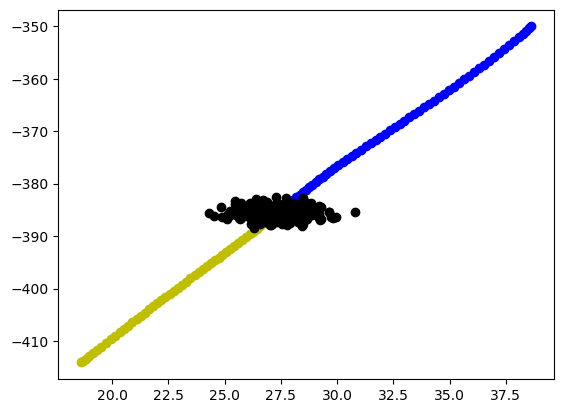

NameError: name 'hungarian_hausdorff_loss' is not defined

In [3]:
from dataset_prepare.argoverse_v2_dataset import ArgoverseV2Dataset
from torch_geometric.data import DataLoader

torch.manual_seed(231)
dataset = ArgoverseV2Dataset('D:\\argoverse2', 'train', None, None, None)
loader = DataLoader(dataset,batch_size=4)
device = torch.device('cuda')

testqc = MikuMikuNet(dataset='argoverse_v2',
                     pl2pl_radius=150,
                     pl2a_radius=50,
                     a2a_radius=50,
                     pl2m_radius=150,
                     a2m_radius=150)

testqc = Area_anchor().to(device)
optimizer = torch.optim.AdamW(testqc.parameters(), lr=1e-2, weight_decay=1e-4)
epoch = 1

for ii in range(epoch):
    print(ii)
    for data in loader:
        optimizer.zero_grad()
        pred,init_raw = testqc(data = data.to(device))
        pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True).squeeze()
        
        loss = 0
        gt = data['agent']['position'][pred_mask,:,:]
        for each_pred,each_gt,i in zip(pred,gt,range(gt.shape[0])):
            each_gt = each_gt[50:,:][data['agent']['predict_mask'][pred_mask][i,50:],:2]
            loss += hungarian_hausdorff_loss(each_pred,each_gt)
        
        loss.backward()
        optimizer.step()
    torch.cuda.empty_cache()
    print(loss)
init_raw = init_raw.detach().cpu().numpy() 
plt.scatter(init_raw[0,:,0], init_raw[0,:,1],c='b')

for data in loader:
    pred,_ = testqc(data = data.to(device))
    pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True).squeeze()
    gt = data['agent']['position'][pred_mask,:,:]
    for each_pred,each_gt,i in zip(pred,gt,range(gt.shape[0])):
        each_gt = each_gt[50:,:][data['agent']['predict_mask'][pred_mask][i,50:],:2]
        each_gt = each_gt.detach().cpu().numpy()
        each_pred = each_pred.detach().cpu().numpy()
        #plt.scatter(each_pred[:,0],each_pred[:,1], c='r')
        #plt.scatter(each_gt[:,0],each_gt[:,1], c='g')
        plt.show()
        break
    break
    

c:\Users\Lenovo\anaconda3\envs\pytorch_py3_9\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


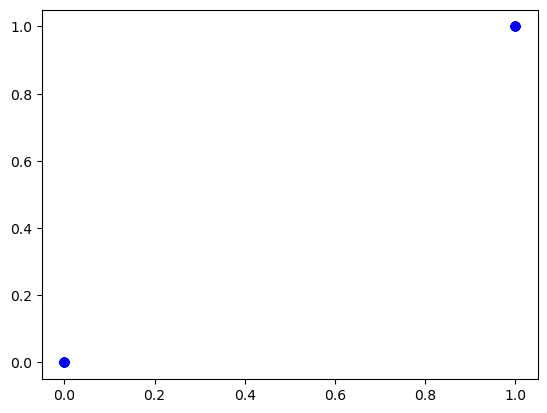

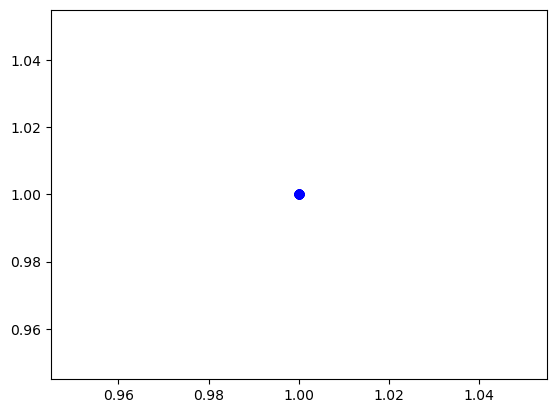

In [11]:
def init_anchor_area(data, history_steps, dim, query_pts_num=400, relative_pos=True):
        device = data['agent']['predict_mask'].device
        pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True)
        init_anchor_list = []
        for each_agent_idx in range(data['agent']['num_nodes']):
            if not pred_mask[each_agent_idx]:
                init_anchor_list.append(torch.zeros(query_pts_num, dim).to(device))
                continue
            ref = data['agent']['position'][each_agent_idx,history_steps,:dim]
            valid_history_steps = (data['agent']['position'][each_agent_idx,:history_steps,:dim].permute(1,0) \
            * data['agent']['valid_mask'][each_agent_idx,:history_steps]).permute(1,0)
            valid_history_steps = valid_history_steps - ref
            proj_pred_pts = - valid_history_steps[data['agent']['valid_mask'][each_agent_idx,:history_steps]]
            try:
                tmp = proj_pred_pts.repeat(query_pts_num // proj_pred_pts.shape[0],1)
                _,r = minimum_enclosing_circle(valid_history_steps[data['agent']['valid_mask'][each_agent_idx,:history_steps],:])
                tmp = (torch.cat((tmp,proj_pred_pts[:query_pts_num % proj_pred_pts.shape[0]]), dim=0) + torch.randn(query_pts_num,dim)*r*0.1)
            except:
                r =torch.tensor([0.01]).to(device)
                tmp = torch.randn(query_pts_num,dim).to(device) * r
            if not relative_pos:
                tmp = (tmp + ref).to(device)
            init_anchor_list.append(tmp)
        init_anchor_pts = torch.stack(init_anchor_list,dim=0)
        
        visualize_num = 40
        showed_data = data['agent']['position'][:, :, :dim].detach().cpu().numpy()
        showused = init_anchor_pts.detach().cpu().numpy()
        plt.scatter(showed_data[visualize_num,:history_steps,0],showed_data[visualize_num,:history_steps,1],c='y')
        plt.scatter(showed_data[visualize_num,history_steps:,0],showed_data[visualize_num,history_steps:,1],c='blue')
        plt.scatter(showused[visualize_num,:,0],showused[visualize_num,:,1],c='black')
        plt.show()
dataset = ArgoverseV2Dataset('D:\\argoverse2', 'train', None, None, None)
loader = DataLoader(dataset,batch_size=4)
device = torch.device('cuda')
for data in loader:
    init_anchor_pts = init_anchor_area(data, 50, 2, 400, relative_pos=False)


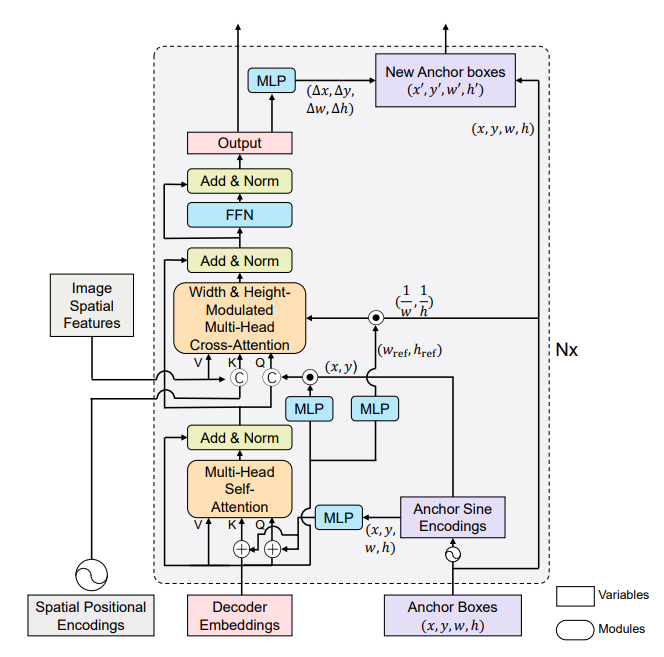

(HeteroDataBatch(
  scenario_id=[8],
  city=[8],
  agent={
    num_nodes=291,
    av_index=[8],
    valid_mask=[291, 110],
    predict_mask=[291, 110],
    id=[8],
    type=[291],
    category=[291],
    position=[291, 110, 3],
    heading=[291, 110],
    velocity=[291, 110, 3],
    batch=[291],
    ptr=[9]
  },
  map_polygon={
    num_nodes=680,
    position=[680, 3],
    orientation=[680],
    height=[680],
    type=[680],
    is_intersection=[680],
    batch=[680],
    ptr=[9]
  },
  map_point={
    num_nodes=13282,
    position=[13282, 3],
    orientation=[13282],
    magnitude=[13282],
    height=[13282],
    type=[13282],
    side=[13282],
    batch=[13282],
    ptr=[9]
  },
  (map_point, to, map_polygon)={ edge_index=[2, 13282] },
  (map_polygon, to, map_polygon)={
    edge_index=[2, 1790],
    type=[1790]
  }
),)

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch_cluster import radius_graph
from torch_cluster import radius
from torch_geometric.data import Batch

import matplotlib.pyplot as plt
from layers import FourierEmbedding


#class Adj_attn()

class Pts_anchor(nn.Module):
    def __init__(self) -> None:
        super(Pts_anchor,self).__init__()
        #self.adj_attn = Adj_atten
        #self.map_attn = Map_attn

    def forward(self, data, history_step=50, dim = 2):
        agent_pts_t0=data['agent']['position'][:,history_step,:dim]
        agent_vel_t0=data['agent']['velocity'][:,history_step,:dim]
        anchor_t1 = self.generate_trajectories(agent_pts_t0, agent_vel_t0)
        print(anchor_t1.shape)
        

        return None
    def generate_trajectories(self, a, b, theta=torch.pi/6, num_traj=7, timestep=0.1):
        """ 
        theta: 最大偏转角
        timestep: 时间步间隔, default=0.1
        num_traj: the number of traj needed to be pred, default = 7 and should be odd
        """
        num_agents = a.shape[0]
        thetas = torch.linspace(-theta, theta, num_traj)
        thetas = thetas.view(num_traj, 1, 1)
        cos_thetas = torch.cos(thetas)  # (num_traj, 1, 1)
        sin_thetas = torch.sin(thetas)  # (num_traj, 1, 1)
        b_expanded = b.unsqueeze(0)  # (1, num_agents, 2)
        rotated_b_x = b_expanded[:, :, 0:1] * cos_thetas - b_expanded[:, :, 1:2] * sin_thetas
        rotated_b_y = b_expanded[:, :, 0:1] * sin_thetas + b_expanded[:, :, 1:2] * cos_thetas
        rotated_b = torch.cat([rotated_b_x, rotated_b_y], dim=2)  # (num_traj, num_agents, 2)
        new_positions = a.unsqueeze(0) + rotated_b * timestep # (num_traj, num_agents, 2)
        c = torch.cat([new_positions, rotated_b], dim=2)  # (num_traj, num_agents, 4)
        return c

class Area_anchor(nn.Module):
    def __init__(self,
                 input_dim_anchor_pts=2,
                 anchor_query_hidden_dim=128,
                 anchor_query_num_freq_bands=64) -> None:
        super(Area_anchor, self).__init__()
        self.query_pos = FourierEmbedding(input_dim=input_dim_anchor_pts, 
                                          hidden_dim=anchor_query_hidden_dim, 
                                          num_freq_bands=anchor_query_num_freq_bands)
        self.query_embed = Area_anchor_embed()

    def forward(self, data, a2m_radius=50, pl2m_radius=50, history_step=50, dim=2, 
                agent2map_pts_max_length=400, std_dev = 2, timest=0.1):
        pos_m = data['agent']['position'][:, history_step, :dim]
        pos_pl = data['map_polygon']['position'][:, :dim]
        edge_index_pl2a = radius(x=pos_m[:, :2],y=pos_pl[:, :2],r=pl2m_radius,
            batch_x=data['agent']['batch'] if isinstance(data, Batch) else None,
            batch_y=data['map_polygon']['batch'] if isinstance(data, Batch) else None,
            max_num_neighbors=300) # dim=0,0:polygon dim=1,0:agent
        agent_history_seq = data['agent']['position'][:, history_step, :dim]
        
        agents2map_pts_pos = []
        agents2map_pts_feat_raw = []
        for each_agent in data['agent']['batch']:
            each_agent_vel = torch.norm(data['agent']['velocity'][each_agent,history_step,:dim])
            each_agent2polygon_index = edge_index_pl2a[:,edge_index_pl2a[1,:] == each_agent][0,:]
            if each_agent2polygon_index.shape[0] == 0:
                tmp = torch.zeros(agent2map_pts_max_length, 2)
                agents2map_pts_pos.append(tmp)
                continue
            each_agent_pt2pl = data['map_point', 'to', 'map_polygon']['edge_index']
            each_agent_pts_index = torch.cat([each_agent_pt2pl[:,each_agent_pt2pl[1, :] == each_][0,:] 
                                    for each_ in each_agent2polygon_index]) 
            each_agent_pts_pos = data['map_point']['position'][each_agent_pts_index,:dim]
            each_agent_pts_mag = data['map_point']['magnitude'][each_agent_pts_index]
            each_agent_pts_ori = data['map_point']['orientation'][each_agent_pts_index]

            # agent2map_pts_pos.append(each_agent_pts_pos)
            tmp = torch.zeros(agent2map_pts_max_length, 2)
            tmp_mag = torch.zeros(agent2map_pts_max_length)
            tmp_ori = torch.zeros(agent2map_pts_max_length)
            if each_agent_pts_pos.shape[0] <= agent2map_pts_max_length:
                try:
                    tmp[:each_agent_pts_pos.shape[0], :] = each_agent_pts_pos
                    tmp[each_agent_pts_pos.shape[0]:, :] = each_agent_pts_pos[:agent2map_pts_max_length-each_agent_pts_pos.shape[0],:]
                except:
                    tmp
                tmp_mag[:each_agent_pts_pos.shape[0]] = each_agent_pts_mag
                tmp_mag[each_agent_pts_pos.shape[0]:] = each_agent_pts_mag[:agent2map_pts_max_length-each_agent_pts_pos.shape[0]]
                tmp_ori[:each_agent_pts_pos.shape[0]] = each_agent_pts_ori
                tmp_ori[each_agent_pts_pos.shape[0]:] = each_agent_pts_ori[:agent2map_pts_max_length-each_agent_pts_pos.shape[0]]
            else:
                print('in')
                tmp = each_agent_pts_pos[:agent2map_pts_max_length,:]
                tmp_ori = each_agent_pts_ori[:agent2map_pts_max_length]
                tmp_mag = each_agent_pts_mag[:agent2map_pts_max_length]
        
        agents2map_pts_pos = torch.stack(agents2map_pts_pos,dim=0)
        query_pos = self.query_pos(continuous_inputs=agents2map_pts_pos, categorical_embs=None)
        #query_embed = self.query_embed()
        
        print(agents2map_pts_pos.shape)

        
        

class Traj_anchor(nn.Module):
    def __init__(self) -> None:
        super(Traj_anchor, self).__init__()


class Area_anchor_embed(nn.Module):
    def __init__(self) -> None:
        super(Area_anchor_embed, self).__init__()
    def forward(self):
        pass



In [235]:
a = torch.tensor([[0,1,1],[1,0,0]])
print(a.shape)
a.unsqueeze(1) & a.unsqueeze(2)

torch.Size([2, 3])


tensor([[[0, 0, 0],
         [0, 1, 1],
         [0, 1, 1]],

        [[1, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]])

In [ ]:

import torch
import torch.nn as nn
from transformers import BertModel, BertConfig

class TransformerEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, num_heads):
        super(TransformerEncoder, self).__init__()
        
        config = BertConfig(
            hidden_size=hidden_dim,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=hidden_dim * 4,
            max_position_embeddings=512,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
        )
        self.encoder = BertModel(config)
        
    def forward(self, x, valid_mask):
        # x: [B, t, dim]
        # valid_mask: [B, t]
        
        # Generate time mask
        seq_length = x.size(1)
        time_mask = torch.triu(torch.ones((seq_length, seq_length)), diagonal=1).bool().to(x.device)
        
        # Combine time mask with valid_mask
        extended_valid_mask = valid_mask[:, None, None, :].to(x.device)
        combined_mask = time_mask[None, None, :, :] | (~extended_valid_mask)
        
        # Attention mask for BERT expects float values (0 or -inf)
        attention_mask = combined_mask.float() * -1e9
        
        # Pass through the transformer encoder
        outputs = self.encoder(inputs_embeds=x, attention_mask=attention_mask)
        
        return outputs.last_hidden_state

# Example usage
batch_size = 8
seq_len = 20
dim = 128
hidden_dim = 128
num_layers = 6
num_heads = 8

model = TransformerEncoder(hidden_dim, num_layers, num_heads)
input_data = torch.randn(batch_size, seq_len, dim)
valid_mask = torch.ones(batch_size, seq_len).bool()  # Example mask

output = model(input_data, valid_mask)
print(output.shape)  # Should print: torch.Size([8, 20, 128])